# Test whether including old data improves performance

We have data from 1963-1997, but only at hourly frequency (whereas the competition data is a 1-minute frequency). This notebook tests whether an hourly model using all the data is better than a high-frequency model trained only on the recent data.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import datetime as dt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from model_definitions import define_model_cnn_1_min, define_model_cnn_hourly
from predict import load_models, predict_batch
from train import train_nn_models
import time
from typing import Callable, Tuple
import tensorflow as tf
from plotting import plot_binned_RMSE
import matplotlib.pyplot as plt


In [2]:
# download and save data
# !wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
# !unzip public.zip
# !wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip
# !unzip private.zip
# !mkdir data
# !mv public data
# !mv private data

In [3]:
# load recent data
data_folder = "data"
solar_train = pd.read_csv(os.path.join(data_folder, "public", "solar_wind.csv"))
dst_train = pd.read_csv(os.path.join(data_folder, "public", "dst_labels.csv"))
sunspots_train = pd.read_csv(os.path.join(data_folder, "public", "sunspots.csv"))
solar_test = pd.read_csv(os.path.join(data_folder, "private", "solar_wind.csv"))
dst_test = pd.read_csv(os.path.join(data_folder, "private", "dst_labels.csv"))
sunspots_test = pd.read_csv(os.path.join(data_folder, "private", "sunspots.csv"))

In [4]:
# train 1-minute model
output_folder = os.path.join("trained_models", "cnn_1_minute", "benchmark")
os.makedirs(output_folder, exist_ok=True)
train_nn_models(solar_train, sunspots_train, dst_train, define_model_cnn_1_min, 1, output_folder, "minute")

Epoch 1/2
4350/4350 [==============================] - 20s 4ms/step - loss: 127.8448 - root_mean_squared_error: 11.1653
Epoch 2/2
4350/4350 [==============================] - 16s 4ms/step - loss: 74.5603 - root_mean_squared_error: 8.6346
Epoch 1/2
4350/4350 [==============================] - 17s 4ms/step - loss: 128.1107 - root_mean_squared_error: 11.1864
Epoch 2/2
4350/4350 [==============================] - 16s 4ms/step - loss: 78.1460 - root_mean_squared_error: 8.8385


In [5]:
# Load older data
solar_old = pd.read_csv(os.path.join(data_folder, "old", "solar_wind.csv"))
dst_old = pd.read_csv(os.path.join(data_folder, "old", "dst_labels.csv"))
sunspots_old = pd.read_csv(os.path.join(data_folder, "old", "sunspots.csv"))
# Merge data - train on old and recent public data, test on recent private data
solar_train_hourly = pd.concat([solar_train, solar_old], axis=0)
sunspots_train_hourly = pd.concat([sunspots_train, sunspots_old], axis=0)
dst_train_hourly = pd.concat([dst_train, dst_old], axis=0)
solar_test_hourly = solar_test.copy()
# Extract hourly data
solar_train_hourly["timedelta"] = pd.to_timedelta(solar_train_hourly["timedelta"])
solar_train_hourly = solar_train_hourly.loc[solar_train_hourly["timedelta"].dt.seconds % 3600 == 0]
solar_test_hourly["timedelta"] = pd.to_timedelta(solar_test_hourly["timedelta"])
solar_test_hourly = solar_test_hourly.loc[solar_test_hourly["timedelta"].dt.seconds % 3600 == 0]

In [6]:
# train hourly model
output_folder = os.path.join("trained_models", "cnn_hourly", "benchmark")
os.makedirs(output_folder, exist_ok=True)
train_nn_models(solar_train_hourly, sunspots_train_hourly, dst_train_hourly, define_model_cnn_hourly, 1, output_folder, "hour")

Epoch 1/5
13685/13685 [==============================] - 43s 3ms/step - loss: 459.0896 - root_mean_squared_error: 21.4088
Epoch 2/5
13685/13685 [==============================] - 42s 3ms/step - loss: 273.3560 - root_mean_squared_error: 16.5318
Epoch 3/5
13685/13685 [==============================] - 42s 3ms/step - loss: 245.9306 - root_mean_squared_error: 15.6818
Epoch 4/5
13685/13685 [==============================] - 42s 3ms/step - loss: 231.8302 - root_mean_squared_error: 15.2254
Epoch 5/5
13685/13685 [==============================] - 41s 3ms/step - loss: 223.1049 - root_mean_squared_error: 14.9361
Epoch 1/5
13685/13685 [==============================] - 42s 3ms/step - loss: 451.1764 - root_mean_squared_error: 21.2274
Epoch 2/5
13685/13685 [==============================] - 42s 3ms/step - loss: 284.9372 - root_mean_squared_error: 16.8779
Epoch 3/5
13685/13685 [==============================] - 42s 3ms/step - loss: 255.3248 - root_mean_squared_error: 15.9784
Epoch 4/5
13685/13685 [=

In [7]:
# measure performance - 1 minute model
output_folder = os.path.join("trained_models", "cnn_1_minute", "benchmark")
model_t_arr, model_t_plus_1_arr, norm_df = load_models(output_folder, 1)
dst_test["timedelta"] = pd.to_timedelta(dst_test["timedelta"])
# exclude times in the first week of dst_test
dst_test = dst_test.loc[dst_test["timedelta"] >= dt.timedelta(days=7)]
predictions = predict_batch(
    solar_test, sunspots_test, dst_test, model_t_arr, model_t_plus_1_arr, norm_df, "minute"
)
dst_test_1_min = pd.merge(dst_test, predictions, "left", ["timedelta", "period"])
dst_test_1_min["dst_t_plus_1"] = dst_test_1_min.groupby("period")["dst"].shift(-1)
loss_t = np.sqrt(
    mean_squared_error(dst_test_1_min["dst"].values, dst_test_1_min["prediction_t"].values)
)
valid_ind = dst_test_1_min["dst_t_plus_1"].notnull()
loss_t_plus_1 = np.sqrt(
    mean_squared_error(
        dst_test_1_min.loc[valid_ind, "dst_t_plus_1"].values,
        dst_test_1_min.loc[valid_ind, "prediction_t_plus_1"].values,
    )
)

print(f"RMSE for time t: {loss_t:0.2f}")
print(f"RMSE for time t+1: {loss_t_plus_1:0.2f}")


RMSE for time t: 12.31
RMSE for time t+1: 12.75


In [8]:
# measure performance - hourly model
output_folder = os.path.join("trained_models", "cnn_hourly", "benchmark")
model_t_arr, model_t_plus_1_arr, norm_df = load_models(output_folder, 1)
predictions = predict_batch(
    solar_test_hourly, sunspots_test, dst_test, model_t_arr, model_t_plus_1_arr, norm_df, "hour"
)
dst_test_hourly = pd.merge(dst_test, predictions, "left", ["timedelta", "period"])
dst_test_hourly["dst_t_plus_1"] = dst_test_hourly.groupby("period")["dst"].shift(-1)
loss_t = np.sqrt(
    mean_squared_error(dst_test_hourly["dst"].values, dst_test_hourly["prediction_t"].values)
)
valid_ind = dst_test_hourly["dst_t_plus_1"].notnull()
loss_t_plus_1 = np.sqrt(
    mean_squared_error(
        dst_test_hourly.loc[valid_ind, "dst_t_plus_1"].values,
        dst_test_hourly.loc[valid_ind, "prediction_t_plus_1"].values,
    )
)

print(f"RMSE for time t: {loss_t:0.2f}")
print(f"RMSE for time t+1: {loss_t_plus_1:0.2f}")

RMSE for time t: 15.46
RMSE for time t+1: 14.84


In [34]:
# blend the two models
dst_test_blend = dst_test_hourly.copy()
hourly_weight = 0.5
dst_test_blend["prediction_t"] = dst_test_hourly["prediction_t"] * hourly_weight + dst_test_1_min["prediction_t"] * (1 - hourly_weight)
dst_test_blend["prediction_t_plus_1"] = dst_test_hourly["prediction_t_plus_1"] * hourly_weight + dst_test_1_min["prediction_t_plus_1"] * (1 - hourly_weight)

loss_t = np.sqrt(
    mean_squared_error(dst_test_blend["dst"].values, dst_test_blend["prediction_t"].values)
)
valid_ind = dst_test_blend["dst_t_plus_1"].notnull()
loss_t_plus_1 = np.sqrt(
    mean_squared_error(
        dst_test_blend.loc[valid_ind, "dst_t_plus_1"].values,
        dst_test_blend.loc[valid_ind, "prediction_t_plus_1"].values,
    )
)

print(f"RMSE for time t: {loss_t:0.2f}")
print(f"RMSE for time t+1: {loss_t_plus_1:0.2f}")

RMSE for time t: 12.86
RMSE for time t+1: 13.05


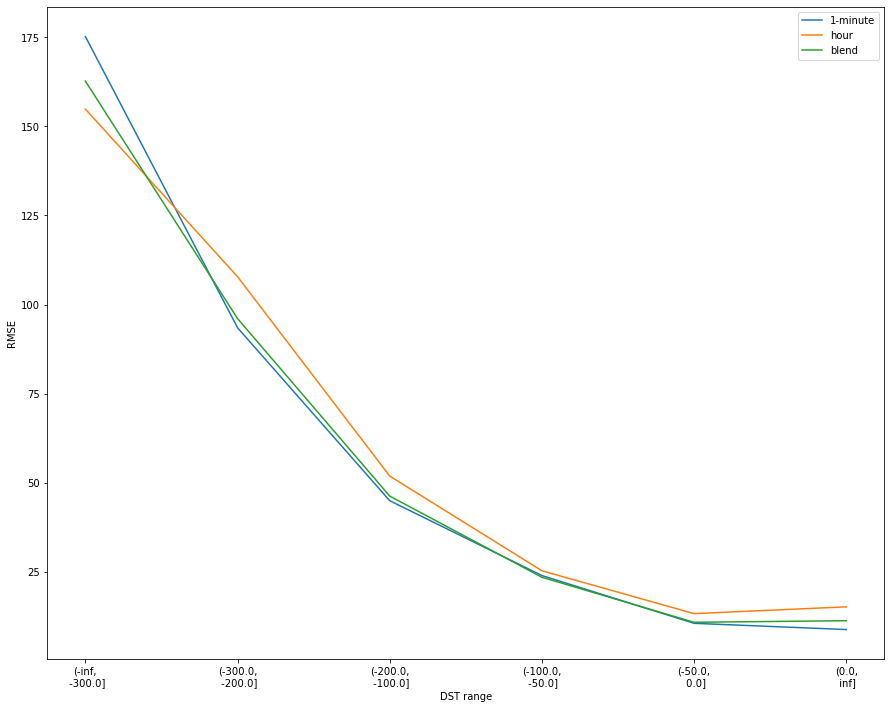

In [35]:
# plot errors in different DST ranges
plt.figure(figsize=(15, 12))
bins = [-np.inf, -300, -200, -100, -50, 0, np.inf]
plot_binned_RMSE(dst_test_1_min.loc[valid_ind, "dst"].values, dst_test_1_min.loc[valid_ind, "prediction_t"].values, bins)
plot_binned_RMSE(dst_test_hourly.loc[valid_ind, "dst"].values, dst_test_hourly.loc[valid_ind, "prediction_t"].values, bins)
plot_binned_RMSE(dst_test_blend.loc[valid_ind, "dst"].values, dst_test_blend.loc[valid_ind, "prediction_t"].values, bins)
plt.legend(["1-minute", "hour", "blend"])

In [24]:
# size of ranges
bin_id = pd.cut(dst_test_1_min.loc[valid_ind, "dst"], bins).to_frame("bin")
bin_id.groupby("bin").size().to_frame("size")

,size
bin,
"(-inf, -300.0]",17
"(-300.0, -200.0]",33
"(-200.0, -100.0]",436
"(-100.0, -50.0]",2516
"(-50.0, 0.0]",43220
"(0.0, inf]",12455
